In [5]:
# Part 1 - EDA (Exploratory Data Analysis)
import json
from pathlib import Path
from typing import Any, Dict, List, Optional

import numpy as np
import pandas as pd

try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_theme(style='whitegrid')
except Exception:
    plt = None
    sns = None

try:
    from wordcloud import WordCloud
except Exception:
    WordCloud = None

try:
    import spacy
    _NLP = spacy.load('en_core_web_sm')
except Exception:
    _NLP = None


# 1. Load processed data

def load_processed_data(path: str | Path) -> pd.DataFrame:
    """loads processed_corpus.json (or JSONL)."""
    p = Path(path)
    if p.suffix.lower() == '.jsonl':
        with p.open('r', encoding='utf-8') as f:
            rows = [json.loads(line) for line in f if line.strip()]
        return pd.DataFrame(rows)
    else:
        return pd.read_json(p, orient='records')


# 2. Dataset summary

def dataset_summary(df: pd.DataFrame) -> pd.DataFrame:
    """rows, columns, missing values, unique counts for categorical fields."""
    # Only include hashable columns
    hashable_cols = [c for c in df.columns if df[c].apply(lambda x: not isinstance(x, list)).all()]
    
    summary = pd.DataFrame({
        'dtype': df.dtypes.astype(str),
        'missing': df.isna().sum(),
        'non_missing': df.notna().sum(),
        'unique': df[hashable_cols].nunique(dropna=True),
    })
    print('Rows:', len(df), '| Columns:', len(df.columns))
    return summary


# 3. Text statistics

def _ensure_tokens_series(df: pd.DataFrame, field: str) -> pd.Series:
    col = df[field]
    return col.apply(lambda x: x if isinstance(x, list) else [])


def text_stats(df: pd.DataFrame, field: str) -> Dict[str, Any]:
    """avg tokens per document, avg length, vocabulary size."""
    tokens_s = _ensure_tokens_series(df, field)
    lengths = tokens_s.apply(len)
    vocab = set(t for toks in tokens_s for t in toks)
    return {
        'avg_tokens_per_doc': float(lengths.mean()) if len(lengths) else 0.0,
        'median_tokens_per_doc': float(lengths.median()) if len(lengths) else 0.0,
        'vocab_size': int(len(vocab)),
    }


def most_common_tokens(df: pd.DataFrame, field: str, top_n: int = 20) -> pd.DataFrame:
    from collections import Counter
    tokens_s = _ensure_tokens_series(df, field)
    counter = Counter(t for toks in tokens_s for t in toks)
    common = counter.most_common(top_n)
    return pd.DataFrame(common, columns=['token', 'freq'])


# 4. Numeric analysis

def numeric_summary(df: pd.DataFrame, field: str) -> Dict[str, float]:
    s = pd.to_numeric(df[field], errors='coerce').dropna()
    if s.empty:
        return {'min': np.nan, 'max': np.nan, 'mean': np.nan, 'median': np.nan, 'std': np.nan}
    return {
        'min': float(s.min()),
        'max': float(s.max()),
        'mean': float(s.mean()),
        'median': float(s.median()),
        'std': float(s.std(ddof=1)) if len(s) > 1 else 0.0,
    }


def plot_numeric_hist(df: pd.DataFrame, field: str, bins: int = 30, title: Optional[str] = None) -> None:
    if plt is None or sns is None:
        print('Plotting libraries not available.')
        return
    s = pd.to_numeric(df[field], errors='coerce')
    plt.figure(figsize=(6, 4))
    sns.histplot(s, bins=bins, kde=True)
    plt.title(title or f'Histogram of {field}')
    plt.xlabel(field)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


def plot_price_vs_rating(df: pd.DataFrame, price_col: str = 'price', rating_col: str = 'rating') -> None:
    if plt is None or sns is None:
        print('Plotting libraries not available.')
        return
    x = pd.to_numeric(df[price_col], errors='coerce')
    y = pd.to_numeric(df[rating_col], errors='coerce')
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=x, y=y, alpha=0.4)
    plt.xlabel(price_col)
    plt.ylabel(rating_col)
    plt.title('Price vs Rating')
    plt.tight_layout()
    plt.show()


# 5. Categorical / stock analysis

def categorical_summary(df: pd.DataFrame, field: str) -> pd.DataFrame:
    s = df[field].astype('string')
    counts = s.value_counts(dropna=True)
    perc = (counts / counts.sum() * 100).round(2)
    return pd.DataFrame({'count': counts, 'percent': perc})


def plot_categorical_bar(df: pd.DataFrame, field: str, top_n: int = 20, title: Optional[str] = None) -> None:
    if plt is None or sns is None:
        print('Plotting libraries not available.')
        return
    s = df[field].astype('string')
    counts = s.value_counts().head(top_n)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=counts.values, y=counts.index)
    plt.title(title or f'Top {top_n} {field}')
    plt.xlabel('Count')
    plt.ylabel(field)
    plt.tight_layout()
    plt.show()


def plot_categorical_pie(df: pd.DataFrame, field: str, top_n: int = 10, title: Optional[str] = None) -> None:
    if plt is None:
        print('Matplotlib not available.')
        return
    s = df[field].astype('string')
    counts = s.value_counts().head(top_n)
    plt.figure(figsize=(6, 6))
    plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title or f'{field} distribution (Top {top_n})')
    plt.tight_layout()
    plt.show()


# 6. Word clouds (optional)

def generate_wordcloud(tokens_list: List[List[str]], title: str = 'Word Cloud') -> None:
    if WordCloud is None or plt is None:
        print('wordcloud/matplotlib not available.')
        return
    text = ' '.join(' '.join(toks) for toks in tokens_list)
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()


# 7. Entity recognition (optional)

def extract_entities(text_list: List[str]) -> pd.DataFrame:
    if _NLP is None:
        print('spaCy model not available.')
        return pd.DataFrame(columns=['text', 'label'])
    ents = []
    for doc in _NLP.pipe(text_list, batch_size=64):
        ents.extend([(ent.text, ent.label_) for ent in doc.ents])
    return pd.DataFrame(ents, columns=['text', 'label'])


# 8. Markdown summary (helper)

def render_markdown_summary(top_brands: pd.DataFrame,
                            top_categories: pd.DataFrame,
                            price_stats: Dict[str, float],
                            rating_stats: Dict[str, float],
                            out_of_stock_ratio: float,
                            token_info: Dict[str, Any]) -> str:
    md = []
    md.append('## EDA Summary')
    md.append(f"- Rows analyzed: {int(top_brands['count'].sum())}")
    md.append(f"- Top brands: {', '.join(top_brands.head(5).index.astype(str))}")
    md.append(f"- Top categories: {', '.join(top_categories.head(5).index.astype(str))}")
    md.append(f"- Price: min {price_stats['min']:.2f}, median {price_stats['median']:.2f}, mean {price_stats['mean']:.2f}, max {price_stats['max']:.2f}")
    md.append(f"- Rating: mean {rating_stats['mean']:.2f}, median {rating_stats['median']:.2f}")
    md.append(f"- Out-of-stock ratio: {out_of_stock_ratio:.2%}")
    md.append(f"- Tokens: avg/doc {token_info['avg_tokens_per_doc']:.1f}, vocab {token_info['vocab_size']}")
    return '\n'.join(md)


Rows: 28080 | Columns: 23


,dtype,missing,non_missing,unique
_id,object,0,28080,28080.0
actual_price,object,0,28080,728.0
average_rating,object,0,28080,39.0
brand,object,0,28080,325.0
category,object,0,28080,4.0
category_clean,object,0,28080,4.0
crawled_at,datetime64[ns],0,28080,16641.0
description,object,0,28080,5684.0
description_clean,object,0,28080,5466.0
details_clean,object,0,28080,22700.0


Text stats: {'avg_tokens_per_doc': 67.51552706552707, 'median_tokens_per_doc': 59.0, 'vocab_size': 8469}


,token,freq
0,neck,57442
1,fabric,57351
2,sleev,51425
3,shirt,50967
4,fit,39765
5,type,38734
6,color,37509
7,cotton,34482
8,pack,29730
9,style,29580


Price stats: {'min': 99.0, 'max': 999.0, 'mean': 535.4256269036592, 'median': 499.0, 'std': 211.76260340165234}
Rating stats: {'min': 1.0, 'max': 5.0, 'mean': 3.6277237693171687, 'median': 3.8, 'std': 0.6634293345254691}


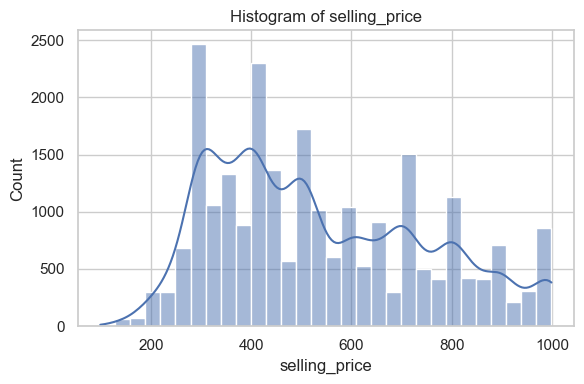

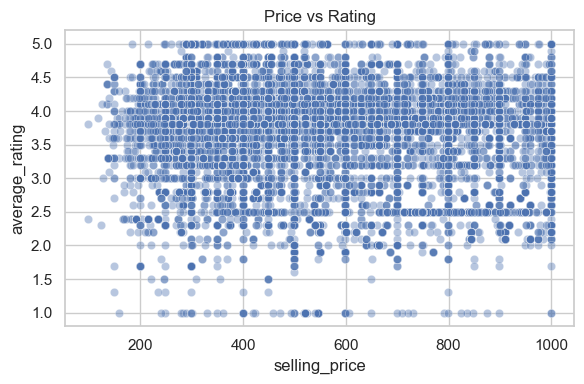

,count,percent
brand,,
,2009,7.15
ECKO Unl,951,3.39
Free Authori,860,3.06
ARBO,806,2.87
REEB,802,2.86
Pu,798,2.84
True Bl,793,2.82
Keo,660,2.35
Amp,585,2.08


,count,percent
category,,
Clothing and Accessories,27118,96.57
Footwear,920,3.28
"Bags, Wallets & Belts",41,0.15
Toys,1,0.0


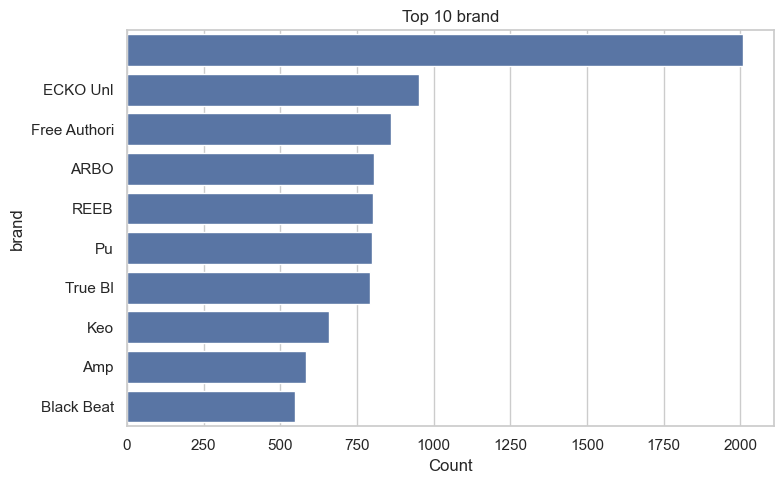

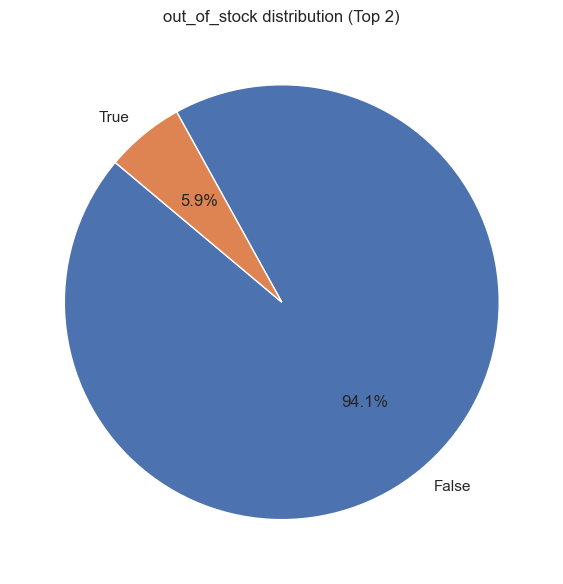

wordcloud/matplotlib not available.
spaCy model not available.


,text,label


## EDA Summary
- Rows analyzed: 28080
- Top brands: , ECKO Unl, Free Authori, ARBO, REEB
- Top categories: Clothing and Accessories, Footwear, Bags, Wallets & Belts, Toys
- Price: min 99.00, median 499.00, mean 535.43, max 999.00
- Rating: mean 3.63, median 3.80
- Out-of-stock ratio: 5.85%
- Tokens: avg/doc 67.5, vocab 8469


In [6]:
# Load processed data
df = load_processed_data("data/processed_corpus.json")

# 1. Dataset summary
summary = dataset_summary(df)
display(summary)

# 2. Text statistics for tokens
token_info = text_stats(df, 'tokens')
print("Text stats:", token_info)
common_tokens = most_common_tokens(df, 'tokens', top_n=20)
display(common_tokens)

# 3. Numeric analysis
price_stats = numeric_summary(df, 'selling_price')
rating_stats = numeric_summary(df, 'average_rating')
print("Price stats:", price_stats)
print("Rating stats:", rating_stats)
plot_numeric_hist(df, 'selling_price')
plot_price_vs_rating(df, 'selling_price', 'average_rating')

# 4. Categorical / stock analysis
top_brands = categorical_summary(df, 'brand')
top_categories = categorical_summary(df, 'category')
display(top_brands.head(10))
display(top_categories.head(10))
plot_categorical_bar(df, 'brand', top_n=10)
plot_categorical_pie(df, 'out_of_stock', top_n=2)

# 5. Word cloud (optional)
generate_wordcloud(df['tokens'].tolist(), title="Most Frequent Tokens")

# 6. Entity recognition (optional)
entities_df = extract_entities(df['description_clean'].astype(str).tolist())
display(entities_df.head(10))

# 7. Markdown summary
out_of_stock_ratio = df['out_of_stock'].mean()
md_summary = render_markdown_summary(top_brands, top_categories, price_stats, rating_stats, out_of_stock_ratio, token_info)
print(md_summary)
